## 1. Example Performance Uploads with Noises

In [25]:
import numpy as np
X = [0.47355184638423353,0.4880126114596745,0.48197951076343787,0.4910955877995803,0.49148326528871633,0.4942378553333534,0.49584690352035904,0.4998314645835072,0.5052953918607438,0.5029510307609053]
A = np.array([X,[0]*len(X)])
sigma = 1.0
personal_noise = (sigma * np.random.randn(2)).reshape((2,1))
print(personal_noise)
B = A + personal_noise
C = B + 0.3 * np.random.randn(len(A),len(A[0]))

[[-0.71952388]
 [ 0.14721603]]


In [26]:
A.shape

(2, 10)

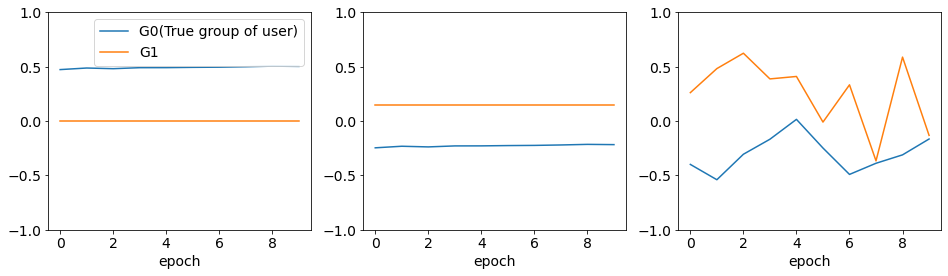

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

plt.figure(figsize = (16, 4))
plt.subplot(1,3,1)
plt.plot(A.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
plt.legend(['G0(True group of user)','G1'])
# plt.title('Original uploads')

plt.subplot(1,3,2)
plt.plot(B.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
# plt.title('After adding personal noise')

plt.subplot(1,3,3)
plt.plot(C.transpose())
plt.ylim(-1.0,1.0)
plt.xlabel('epoch')
# plt.title('After adding epoch noise')
plt.show()

## Choosing Sigma

In [128]:
import numpy as np
from scipy.stats import norm
def get_lower_bound(X, delta_1):
    return X / (np.sqrt(2)*norm.ppf(0.5+delta_1))
def get_upper_bound(X_actual, H, N, delta_2):
    return H * X_actual * np.sqrt(N * delta_2)

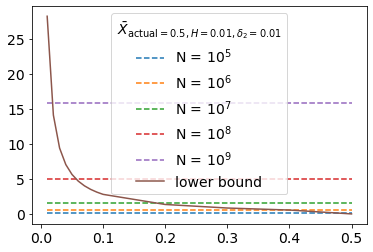

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
delta_list = [0.01*i for i in range(1,10)] + [0.1*i for i in range(1,6)]
for p in range(5,10):
    plt.plot(delta_list, [get_upper_bound(0.5, 0.01, 10**p, 0.01)] * len(delta_list), '--', label = f'N = $10^{p}$')
lbs = [get_lower_bound(1., delta_1) for delta_1 in delta_list]
plt.plot(delta_list, lbs, label = 'lower bound')
plt.legend(title = r'$\bar{X}_{\mathrm{actual}=0.5,H=0.01,\delta_2=0.01}$')
plt.show()

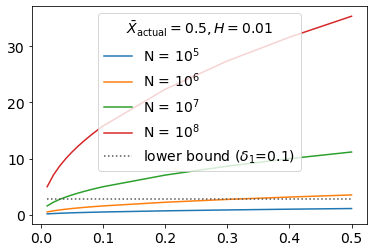

In [131]:
N = 1000000
X_actual = 0.5
H = 0.01
for p in range(5,9):
    N = 10**p
    ubs = [get_upper_bound(X_actual, H, N, delta_2) for delta_2 in delta_list]
    plt.plot(delta_list, ubs, label = f'N = $10^{p}$')
plt.plot(delta_list, [get_lower_bound(1., 0.1)] * len(delta_list), ':', color = '#555555', label = r'lower bound ($\delta_1$=0.1)')
plt.legend(title = r'$\bar{X}_\mathrm{actual}=0.5,H=0.01$')
plt.show()

## 2. Group Differences during Training

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [173]:
ROOT="/home/sl1471/workspace/experiments/"
group_feature = 'activity'
best_setting = {'ml-1m': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
                              f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda-0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00003_reg0.1_losspairwisebpr_lambda0.9_g{group_feature}.log'
                          ],
                          'F2MF': [
#                               f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.9_sigma0_g{group_feature}.log'
                              f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.7_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.5_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.3_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda-0.1_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.1_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.3_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.5_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.7_sigma0.01_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg0.1_losspairwisebpr_lambda0.9_sigma0.01_g{group_feature}.log'
                          ]
                         },
               'amz_Movies_and_TV': {'MF': [], 
                          'FedMF': [], 
                          'FairMF': [
                              f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda-0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.1_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.3_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.5_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.7_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairMF_lr0.00001_reg1.0_losspairwisebpr_lambda0.9_g{group_feature}.log'
                          ],
                          'F2MF': [
#                               f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.7_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.5_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.3_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda-0.1_sigma0_g{group_feature}.log'
                              f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.1_sigma0_g{group_feature}.log'
                              ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.3_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.5_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.7_sigma0_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.03_reg1.0_losspairwisebpr_lambda0.9_sigma0_g{group_feature}.log'
#                               f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.1_sigma0.01_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.3_sigma0.01_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.5_sigma0.01_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.7_sigma0.01_g{group_feature}.log'
#                               ,f'/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.9_sigma0.01_g{group_feature}.log'
                          ]
                         }}

In [174]:
from utils import extract_args, extract_epochwise_result
import numpy as np
groups = []
# data_key = 'ml-1m'
data_key = 'amz_Movies_and_TV'
# data_key = 'amz_Books'
training_curves = {} # {fair_lambda: {group_feature: [values]}}
D = {} # {fair_lambda: {group_feature: [values]}}
for log_name in best_setting[data_key]['F2MF']:
    log_file_path = ROOT + data_key + log_name
    args = extract_args(log_file_path)
    observation_result = extract_epochwise_result(log_file_path, 'Previous statistics:')
    if len(groups) == 0:
        groups = [G for G in observation_result[0]]
    training_curves[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in observation_result])
                                         for G in groups}
    D_log = extract_epochwise_result(log_file_path, 'D:', next_line = False)
    D[args.fair_lambda] = {G: np.array([epoch_result[G] for epoch_result in D_log])
                                         for G in groups}
# print(training_curves)

/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.1_sigma0_gactivity.log
/home/sl1471/workspace/experiments/amz_Movies_and_TV/logs/f2rec_train_and_eval_FairFedMF_lr0.003_reg1.0_losspairwisebpr_lambda0.3_sigma0_gactivity.log


In [175]:
group_differences = {} # {fair_lambda: [value]}
for lbd, group_curves in training_curves.items():
    L = len(group_curves[groups[0]])
    diff_sum,diff_count = np.zeros(L),0.
    for i,G0 in enumerate(groups):
        curve0 = group_curves[G0]
        for G1 in groups[i+1:]:
            curve1 = group_curves[G1]
            diff_sum += np.abs(curve1 - curve0)
            diff_count += 1
    group_differences[lbd] = diff_sum / diff_count
print(group_differences)

{0.1: array([0.00000000e+00, 3.40637132e-06, 2.69236241e-05, 4.87437141e-05,
       6.66867307e-05, 8.40171018e-05, 9.50056498e-05, 1.17992467e-04,
       1.30725392e-04, 1.39741656e-04, 1.44375729e-04, 1.71369129e-04,
       1.75546955e-04, 2.08121684e-04, 1.98016301e-04, 2.16173158e-04,
       2.32136072e-04, 2.43706771e-04, 2.50002866e-04, 2.33540723e-04,
       2.60228907e-04, 2.85111883e-04, 2.79516623e-04, 2.99279126e-04,
       2.79558427e-04, 2.99373425e-04]), 0.3: array([0.00000000e+00, 3.40637132e-06, 2.69236241e-05, 4.36725042e-05,
       5.68612117e-05, 6.98603775e-05, 7.74026279e-05, 9.54973688e-05,
       1.04750418e-04, 1.11163526e-04, 1.12921748e-04, 1.35851748e-04,
       1.37959882e-04, 1.65302326e-04, 1.55086026e-04, 1.69589859e-04,
       1.83783378e-04, 1.92167860e-04, 1.97126586e-04, 1.79872518e-04,
       2.04612934e-04, 2.26233025e-04, 2.19856950e-04, 2.37491836e-04,
       2.17252903e-04, 2.34970067e-04, 2.32532633e-04, 2.55789820e-04,
       2.49866219e-04, 2.

In [176]:
# plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
# title = 'ML1M(activity)'
# plot_stats[title] = group_differences
# print(plot_stats)

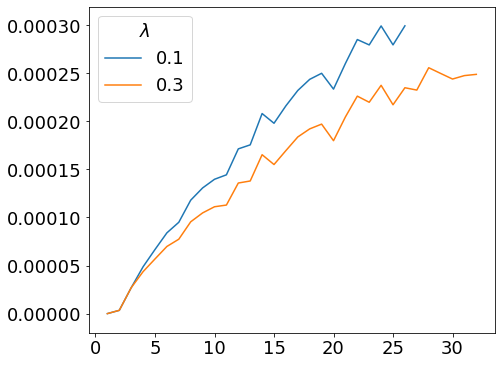

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils import plot_multiple_line
plt.rcParams.update({'font.size': 18})
data_name = {"ml-1m": 'ML1M', 'amz_Movies_and_TV': 'Movies', 'amz_Books': 'Books', 'amz_Electronics': 'Electronics'}
title = f'{data_name[data_key]}({group_feature})'
plot_multiple_line({'': group_differences}, [''], ncol = 2,
                   ylabel = '', xlabel = '', legend_title = '$\lambda$')

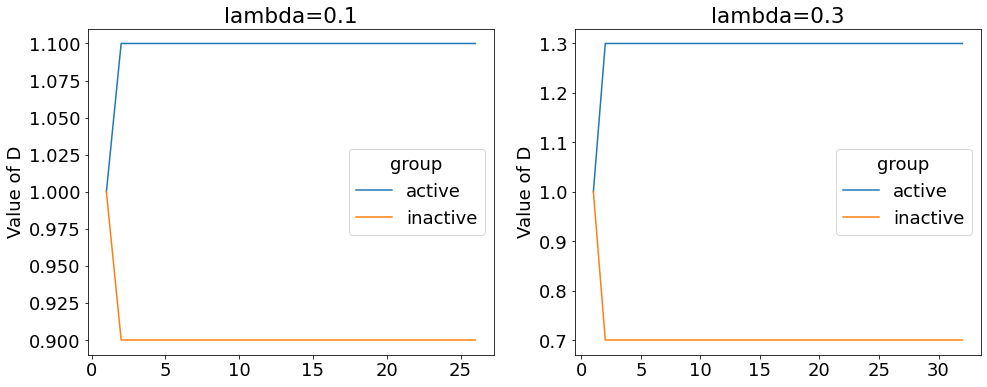

In [178]:
plt.rcParams.update({'font.size': 18})
title = 'ML1M(activity)'
plot_stats = {f'lambda={lbd}': group_D for lbd, group_D in D.items()}
plot_multiple_line(plot_stats, list(plot_stats.keys()), ncol = 2, row_height = 6,
                   ylabel = 'Value of D', xlabel = '', legend_title = 'group')